# Imports and loading sample temperature maxima data

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3
import theano
import itertools
from sta642_code import *
from scipy.stats import exponweib, genextreme
import theano.tensor as tt
from theano.compile.ops import as_op
from scipy.stats import invwishart as iw
from numpy import identity
from __future__ import division
from scipy.stats import invgamma
import seaborn as sns
import geopandas as gpd
import scipy.stats
from pymc3.distributions.dist_math import bound
%matplotlib inline
np.set_printoptions(precision=2)

values = pd.read_csv('./temp_max_81_stations.csv',index_col = 0)
values.index = pd.to_datetime(values.index)
maxima = values.groupby(values.index.year).max().dropna(axis=1) - 273.15
longitudes = [-102.0,-101.0,-100.0,-99.0,-98.0,-97.0,-96.0,-95.0,-94]
latitudes  = [34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0]
prods = list(itertools.product(longitudes,latitudes))

# Import multiple time series and convert to maxima
### Do not run unless needed - takes a long time to execute

In [2]:
longitudes = [-102.0,-101.0,-100.0,-99.0,-98.0,-97.0,-96.0,-95.0,-94]
latitudes  = [34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0]
prods = list(itertools.product(longitudes,latitudes))
productLongitudes,productLatitudes = zip(*prods)
values_temp = retrieveGridmetAtLocations(productLatitudes,productLongitudes,False,seriesToDownload = ['tmmx'])
values_prcp = retrieveGridmetAtLocations(productLatitudes,productLongitudes,False,seriesToDownload = ['prcp'])
maxima = values.groupby(values.index.year).max().dropna(axis=1) - 273.15
values.to_csv('./temp_max_81_stations.csv')

# Basic time series model

# Weibull model with shared shape parameter and unique scale for each site

In this first model, we are going to look at 10 stations and assume that the maximum annual temperature recorded at each site, for each year is distributed according to a Weibull distribution. We'll allow for a different scale parameter (beta) at each location, but all the sites will share a common shape parameter (alpha). We'll generate trace plots of the parameter samples as the MCMC proceeds as well as a plot of the posterior over alpha and beta

100%|██████████| 1000/1000 [00:02<00:00, 527.44it/s]


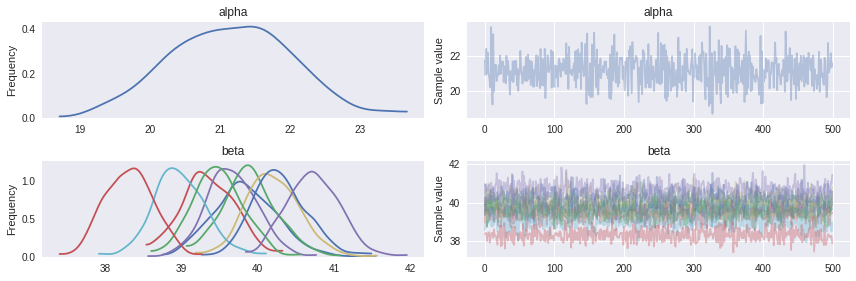

In [447]:
r = 10 # Number of weather stations
reduced_maxima = maxima[maxima.columns[0:r]]
t = reduced_maxima.shape[0] # Number of observations per site

with pymc3.Model() as model:
    alpha = pymc3.InverseGamma('alpha',alpha = 1.0, beta = 1.0)
    beta  = pymc3.Lognormal('beta',mu = 2.0, sd = 2.0, shape = r)
    x     = pymc3.Weibull('x',alpha = alpha, beta = beta, shape=[t,r ],observed = reduced_maxima )
    trace = pymc3.sample()
    _ = pymc3.traceplot(trace)
  


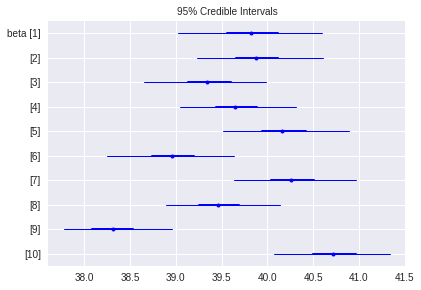

In [448]:
_ = pymc3.plots.forestplot(trace, varnames=['beta'])

The next thing we'll do is pose a simple hypothesis test: has the scale of temperature maxima increased between 1985 - 2000 and 2000-2015? In order to answer this, we will assign each station a scale parameter $\beta_{pre}$ for pre-2000 and $\beta_{post}$ for post-2000. The shared shape parameter will be carried over from the previous case. Then, we will generate Monte Carlo samples of the ratio $\beta_{pre} / \beta_{post}$. If the posterior places little probability mass near the 1.0 for this ratio, then we judge that there has been a statistically significant change.

100%|██████████| 1000/1000 [00:07<00:00, 253.25it/s]


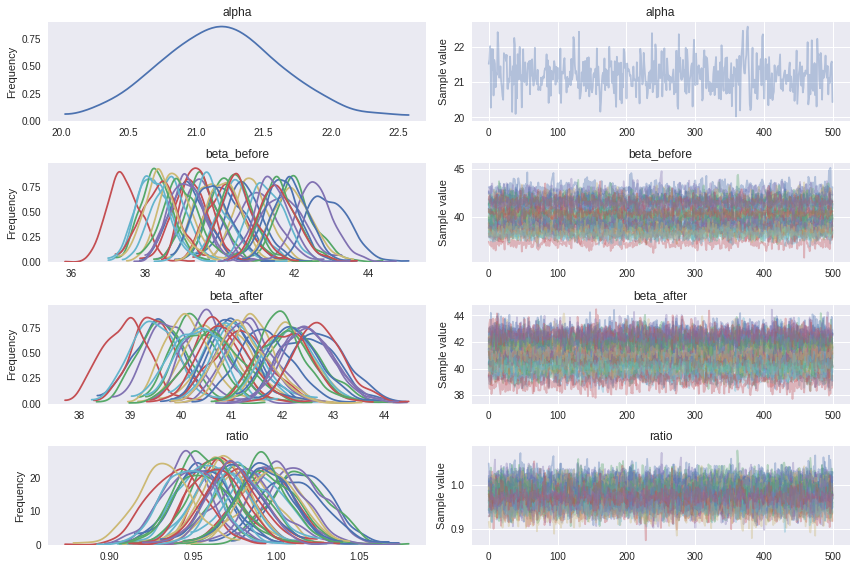

In [449]:
r = 40 # Number of weather stations
split_index = 16
reduced_maxima = maxima[maxima.columns[0:r]]
t = reduced_maxima.shape[0] # Number of observations per site

before_maxima = reduced_maxima.loc[1985:2000]
t_before = before_maxima.shape[0]

after_maxima = reduced_maxima.loc[2000::]
t_after = after_maxima.shape[0]

with pymc3.Model() as model:
    alpha        = pymc3.InverseGamma('alpha',alpha = 1.0, beta = 1.0)
    
    beta_before  = pymc3.Lognormal('beta_before',mu = 2.0, sd = 2.0, shape = r)
    beta_after   = pymc3.Lognormal('beta_after',mu = 2.0, sd = 2.0, shape = r)
    
    ratio        = pymc3.Deterministic('ratio', beta_before / beta_after)
    
    x_before     = pymc3.Weibull('x_before',alpha = alpha, beta = beta_before, shape=[t_before,r ],observed = before_maxima )
    x_after      = pymc3.Weibull('x_after',alpha = alpha, beta = beta_after, shape=[t_after,r ],observed = after_maxima )

    trace = pymc3.sample()
    pymc3.traceplot(trace)


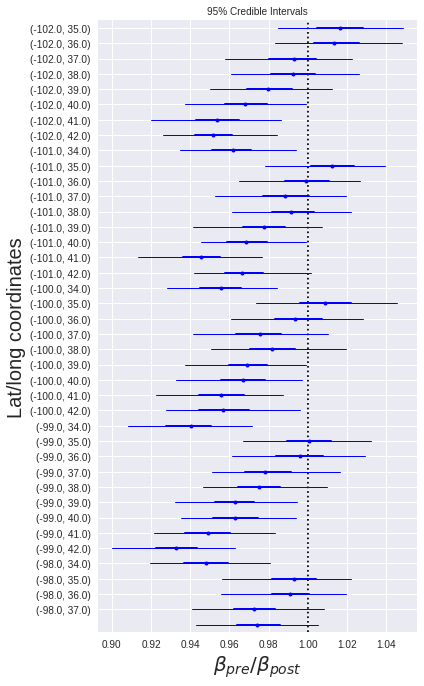

In [450]:
locations_as_strings = [str(x) for x in prods]
plt.figure(figsize = (6,10))
_ = pymc3.plots.forestplot(trace, varnames=['ratio'],vline = 1.0,ylabels = locations_as_strings[1:r])
plt.ylabel('Lat/long coordinates',fontsize = 20)
plt.xlabel('$\\beta_{pre} / \\beta_{post}$',fontsize = 20)

What we see here is interesting. Note that the ordering of the ratios is determined by the order of the columns in the pandas dataframe that this data originally came from. The ylabels on this plot denote the (longitude, latitude) of where the weather data came from. These results suggest that for northern latitudes, the ratios of the scale parameters is significantly nonzero - the 95% CI does not include zero in many of these cases. This provides strong evidence of an increase in the annual maximum temperature for northern latitudes ( latitude > 39.0 degrees) with weak/no evidence for more southerly latitudes.

The next thing we'll do here is use the data from all 81 stations, determine which ones have a ratio significantly greater or less than 1.0 and plot these locations on a map. I've downloaded a shapefile of USA states from this link: https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html.

In [451]:
r = 81 # Number of weather stations
split_index = 16
reduced_maxima = maxima[maxima.columns[0:r]]
t = reduced_maxima.shape[0] # Number of observations per site

before_maxima = reduced_maxima.loc[1985:2000]
t_before = before_maxima.shape[0]

after_maxima = reduced_maxima.loc[2000::]
t_after = after_maxima.shape[0]

with pymc3.Model() as pooled_alpha_model: # The naming convention for this model will make sense later.
    alpha        = pymc3.InverseGamma('alpha',alpha = 1.0, beta = 1.0)
    
    beta_before  = pymc3.Lognormal('beta_before',mu = 2.0, sd = 2.0, shape = r)
    beta_after   = pymc3.Lognormal('beta_after',mu = 2.0, sd = 2.0, shape = r)
    
    ratio        = pymc3.Deterministic('ratio', beta_before / beta_after)
    
    x_before     = pymc3.Weibull('x_before',alpha = alpha, beta = beta_before, shape=[t_before,r ],observed = before_maxima )
    x_after      = pymc3.Weibull('x_after',alpha = alpha, beta = beta_after, shape=[t_after,r ],observed = after_maxima )

    pooled_alpha_trace = pymc3.sample()
    
    
ratio_monte_carlo_upper        = np.percentile(pooled_alpha_trace['ratio'],95,axis = 0)
ratio_monte_carlo_lower        = np.percentile(pooled_alpha_trace['ratio'],5,axis = 0)
is_ratio_significant           = np.logical_or(ratio_monte_carlo_upper < 1.0,ratio_monte_carlo_lower > 1.0)
ratio_monte_carlo_mean         = np.mean(pooled_alpha_trace['ratio'],axis = 0)


100%|██████████| 1000/1000 [00:23<00:00, 42.10it/s]


We'll use Geopandas to simplify some of the plotting work.

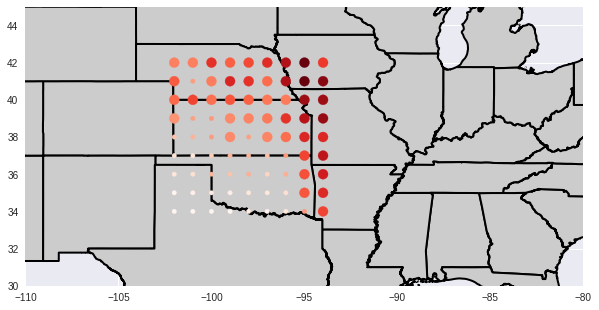

In [452]:
from shapely.geometry import Point
import geopandas as gpd

geometry = [Point(xy) for xy in prods]
crs = {'init': 'epsg:4326'}
geodf = gpd.GeoDataFrame(index = range(81),crs=crs,geometry = geometry,)
geodf['ratio'] = ratio_monte_carlo_mean
geodf['significance'] = is_ratio_significant


states = gpd.read_file('./project/cb_2016_us_state_500k.shp')
states_ax = states.plot(figsize = (10,10),edgecolor='k',facecolor='0.8',linewidth = 2.0)
plt.ylim([30.0,45.0])
plt.xlim([-110.0,-80.0])

geodf.plot(column ='ratio', ax = states_ax,cmap ='Reds_r',markersize = 20,vmax = 1.0 )
_ = geodf.plot(column ='ratio', ax = states_ax,cmap ='Reds_r',markersize = 100 * is_ratio_significant,vmax = 1.0 )


In this map, the small circles correspond to locations with no significant difference and the large circles show significant change. The color indicates the severity of this change. 

# Weibull model with unique shape and scale parameter

The assumption that there is a single shape parameter for all the locations shown above might be unrealistic. Consequently, we should also consider a model in which the shape parameter is allowed to vary per location. We'll repeat our before/after analysis with this modification.

In [453]:
r = 81 # Number of weather stations
split_index = 16
reduced_maxima = maxima[maxima.columns[0:r]]
t = reduced_maxima.shape[0] # Number of observations per site

before_maxima = reduced_maxima.loc[1985:2000]
t_before = before_maxima.shape[0]

after_maxima = reduced_maxima.loc[2000::]
t_after = after_maxima.shape[0]

with pymc3.Model() as individual_alpha_model:
    alpha        = pymc3.InverseGamma('alpha',alpha = 1.0, beta = 1.0,shape = r)
    
    beta_before  = pymc3.Lognormal('beta_before',mu = 2.0, sd = 2.0, shape = r)
    beta_after   = pymc3.Lognormal('beta_after',mu = 2.0, sd = 2.0, shape = r)
    
    ratio_varying_alpha        = pymc3.Deterministic('ratio_varying_alpha', beta_before / beta_after)
    
    x_before     = pymc3.Weibull('x_before',alpha = alpha, beta = beta_before, shape=[t_before,r ],observed = before_maxima )
    x_after      = pymc3.Weibull('x_after',alpha = alpha, beta = beta_after, shape=[t_after,r ],observed = after_maxima )

    individual_alpha_trace = pymc3.sample()

100%|██████████| 1000/1000 [00:25<00:00, 38.76it/s]


The next two plots are very large - this is because we are looking at posterior summaries for 81 different locations and for 2 quantities for each location.

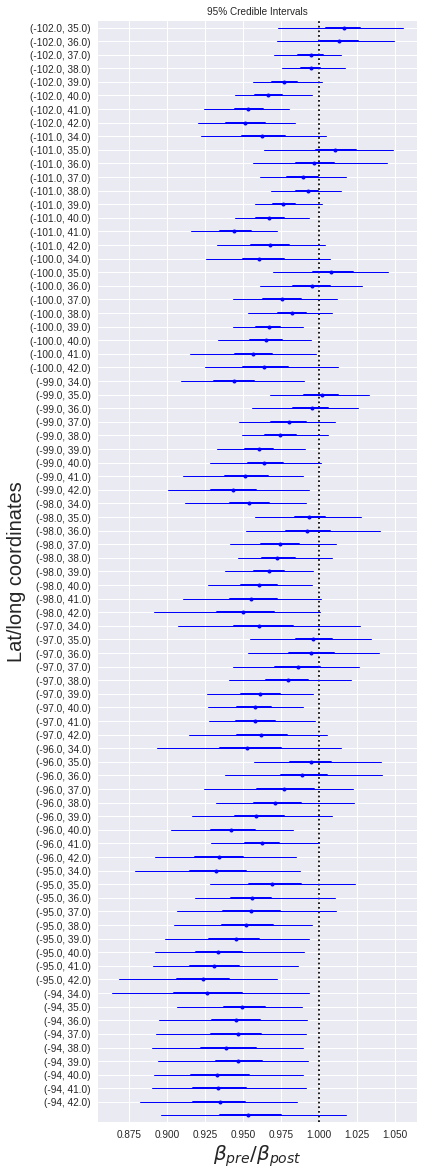

In [454]:
plt.figure(figsize = (6,18))
pymc3.plots.forestplot(individual_alpha_trace, varnames=['ratio_varying_alpha'],vline = 1.0,ylabels = locations_as_strings[1:r])
plt.ylabel('Lat/long coordinates',fontsize = 20)
_ = plt.xlabel('$\\beta_{pre} / \\beta_{post}$',fontsize = 20)

Here, we still see that many of the ratios are significantly different from 1.0.

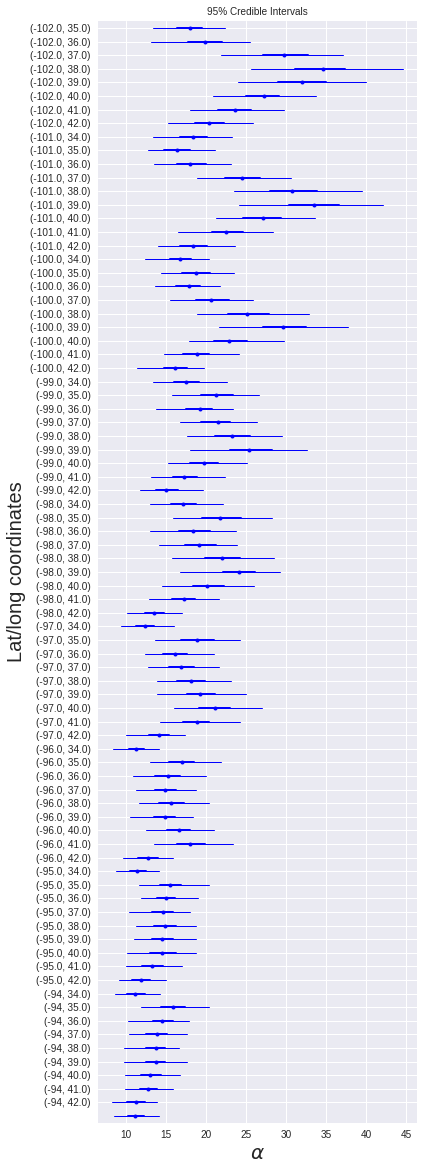

In [455]:
plt.figure(figsize = (6,18))
_ = pymc3.plots.forestplot(individual_alpha_trace, varnames=['alpha'],vline = 1.0,ylabels = locations_as_strings[1:r])
plt.ylabel('Lat/long coordinates',fontsize = 20)
plt.xlabel('$\\alpha$',fontsize = 20)

Furthermore, this plot is evidence that our restriction of a single shape parameter $\alpha$ for the entire study area was not a very good one as the posteriors for $\alpha$ range from 10 to 40.

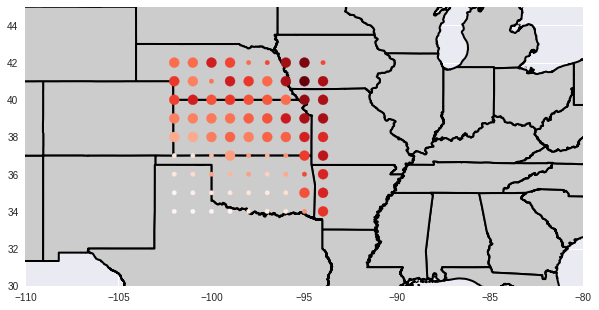

In [456]:
ratio_monte_carlo_upper        = np.percentile(individual_alpha_trace['ratio_varying_alpha'],95,axis = 0)
ratio_monte_carlo_lower        = np.percentile(individual_alpha_trace['ratio_varying_alpha'],5,axis = 0)
geodf['significance_varying_alpha']       = np.logical_or(ratio_monte_carlo_upper < 1.0,ratio_monte_carlo_lower > 1.0)
geodf['ratios_varying_alpha']  = np.mean(individual_alpha_trace['ratio_varying_alpha'],axis = 0)


states_ax = states.plot(figsize = (10,10),edgecolor='k',facecolor='0.8',linewidth = 2.0)
plt.ylim([30.0,45.0])
plt.xlim([-110.0,-80.0])
geodf.plot(column ='ratios_varying_alpha', ax = states_ax,cmap ='Reds_r',markersize = 20,vmax = 1.0 )
_ = geodf.plot(column ='ratios_varying_alpha', ax = states_ax,cmap ='Reds_r',markersize = 100 * geodf['significance_varying_alpha'] ,vmax = 1.0 )   

Interestingly, we actually get more statistically significant results for increases in $\beta_{post}$ relative to the model in which $\alpha$ was not allowed to vary geographically. Note that the colormap is not equivalent; GeoPandas struggles with getting an appropriate colorbar to be shown and I haven't gone through the effort of putting it in here.

Finally, we'll end this chapter with a model comparison.

In [457]:
pymc3.compare((pooled_alpha_trace, individual_alpha_trace), (pooled_alpha_model, individual_alpha_model))

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,12148.5,241.16,0,0.94,73.6,0,1
0,12347.4,214.89,198.92,0.06,82.44,33.34,1


The model with individual $\alpha$ parameters appears to be the best.

# GEV Modeling

In the previous section, we modeled the temperature extremes as draws from a Weibull distribution. Next, we'll use the generalized extreme value (GEV) distribution to characterize these events instead. We're specifically intereste in the movement of the location parameter $\mu_t$ over time for each observation site. We will also incorporate a process convolution model which gives us a simple spatial representation.

# Basic testing of PyMC3 with custom GEV likelihood

First, we just want to see whether we can recover the true parameters via MCMC.

100%|██████████| 1000/1000 [00:00<00:00, 2523.60it/s]


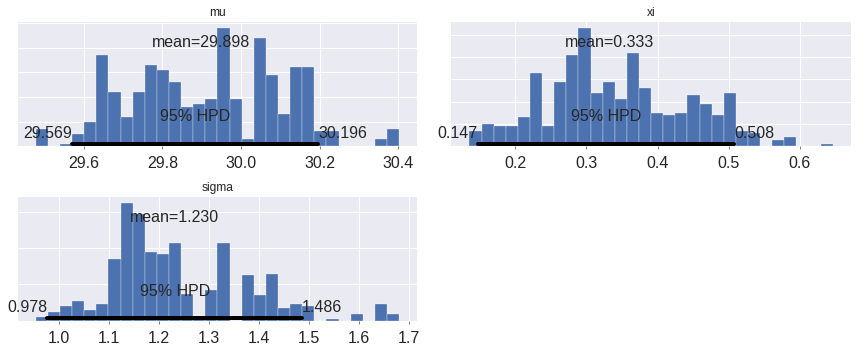

In [23]:
# This is a theano-ized verson of a GEV likelihood.
def gev_ll(loc,c,scale):
    def gev_logp(value):
        scaled = (value - loc) / scale
        logp = -(scale
                 + ((c + 1) / c) * tt.log1p(c * scaled)
                 + (1 + c * scaled) ** (-1/c))
        alpha = loc - scale / c
        bounds = tt.switch(value > 0, value > alpha, value < alpha)
        return bound(logp, bounds, c != 0)
    return gev_logp

num_samples = 35

true_mu = 30.0
true_sigma = 1.2
true_xi = 0.3
simulated = genextreme.rvs(c = -true_xi,scale = true_sigma,loc = true_mu,size = num_samples)

with pymc3.Model() as basic_gev_model:
    mu    = pymc3.Normal('mu',mu = 0.0, sd = 100.0)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,testval = 1.0)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,testval = 1.0)
    observations = pymc3.DensityDist('observations',gev_ll(mu,xi,sigma),
                                     observed = simulated)
    trace = pymc3.sample(step = [pymc3.Metropolis()])
    pymc3.plot_posterior(trace)

# Testing GEV distribution with observed temperature maxima

100%|█████████▉| 11967/12000 [01:28<00:00, 385.44it/s]/home/ubuntu/anaconda2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 50 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 12000/12000 [01:28<00:00, 134.87it/s]


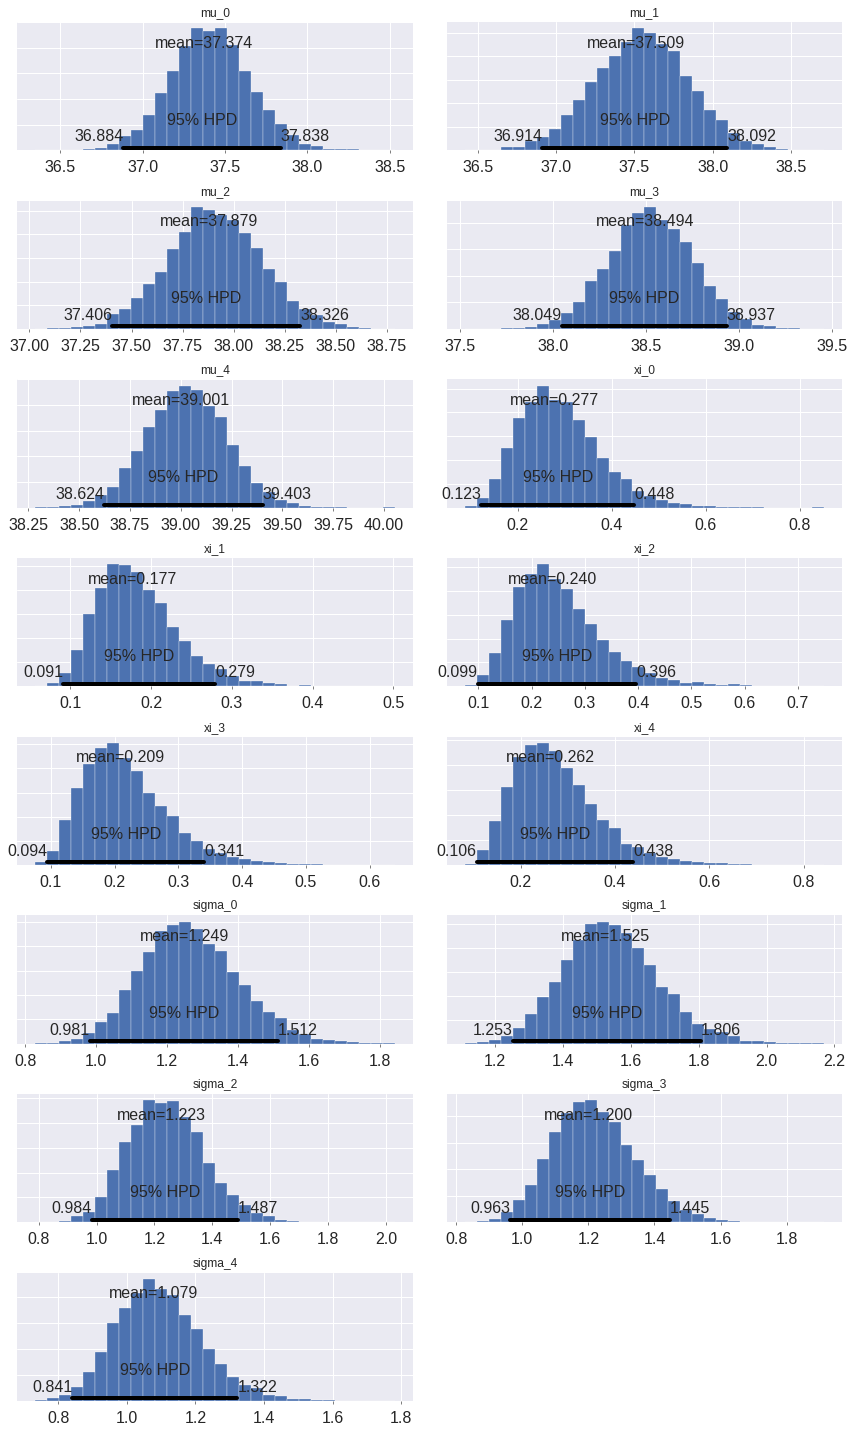

In [259]:
r = 5
T = 31
observations  = maxima.values[:,0:5]

with pymc3.Model() as basic_gev_model:
    mu    = pymc3.Normal('mu',mu = 25.0, sd = 100.0,testval = 3.0,shape = r)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,
                               testval = 1.0,shape = r)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,
                               testval = 1.0,shape = r)
    z = pymc3.DensityDist('z',gev_ll(mu,xi,sigma),
                                     observed = observations)
    trace = pymc3.sample(draws = 10000,tune = 2000)
    pymc3.plot_posterior(trace)

# GEV model with linear regression across multiple sites

100%|█████████▉| 2986/3000 [00:17<00:00, 329.80it/s]/home/ubuntu/anaconda2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3000/3000 [00:17<00:00, 173.09it/s]


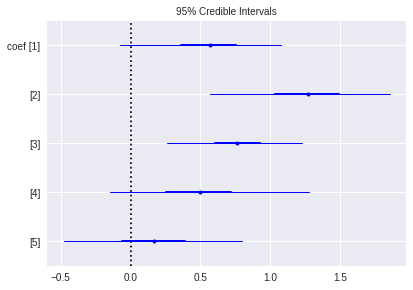

In [131]:
r = 5
T = 31
observations  = maxima.values[:,0:5]

with pymc3.Model() as trend_gev_model:
    
    trend   = np.linspace(-1.0,1.0,T)[:,np.newaxis].repeat(r,axis=1)
    base    = pymc3.Normal('base',mu = 25.0, sd = 100.0,testval = 3.0,shape = r)
    coef    = pymc3.Normal('coef',mu = 0.0, sd = 1.0,shape = r)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,
                               testval = 1.0,shape = r)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,
                               testval = 1.0,shape = r)
    mu = pymc3.Deterministic('mu',trend*coef + base)
    z = pymc3.DensityDist('z',gev_ll(mu,xi,sigma),
                                     observed = observations)
    trend_gev_trace = pymc3.sample(draws = 1000,tune = 2000)
    pymc3.forestplot(trend_gev_trace,varnames=['coef'])

### KDE plot of observed versus MC medians

(20.0, 50.0)

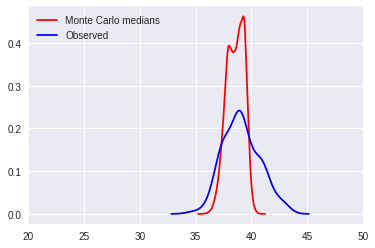

In [130]:
sample_medians = genextreme.median(-trend_gev_trace['xi'][:,np.newaxis,:].repeat(T,axis = 1),
                                        loc=trend_gev_trace['mu']
                                        ,scale=trend_gev_trace['sigma'][:,np.newaxis,:].repeat(T,axis = 1)).ravel()
sns.kdeplot(sample_medians,color='r',label = 'Monte Carlo medians')
sns.kdeplot(observations.ravel(),color='b',label='Observed' )
_ = plt.xlim([20.0,50.0])

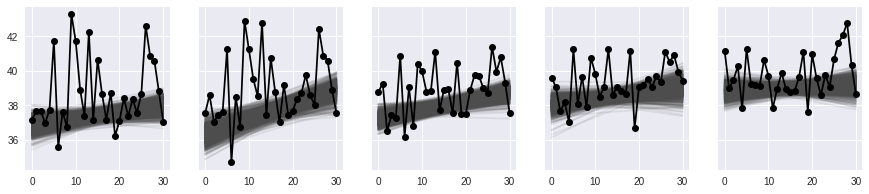

In [145]:
f,ax = plt.subplots(1,5,figsize = (15,3),sharey=True)
for index in range(5):

    ax[index].plot(observations[:,index],color = 'k',marker='o',zorder=2)
    ax[index].plot(trend_gev_trace['mu'][:,:,index].T,alpha = 0.1,color='0.3',zorder=1)

## GEV model with linear trend and spatial process convolution

100%|█████████▉| 2497/2500 [01:31<00:00, 34.90it/s]/home/ubuntu/anaconda2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 5 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [01:31<00:00, 27.32it/s]


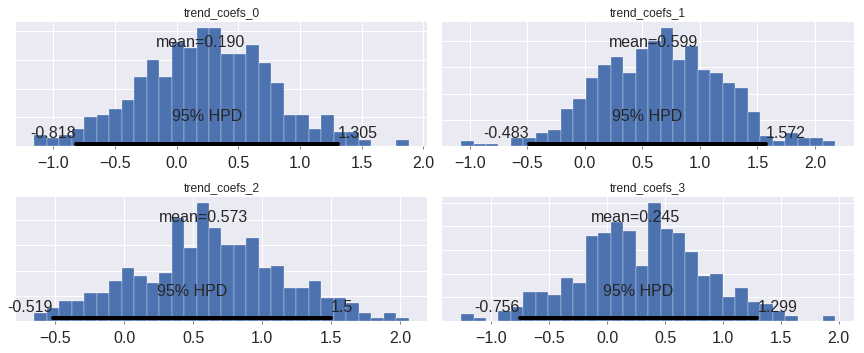

In [295]:
observations = maxima.values
T,r = observations.shape
n = 4
kernel_sites= [(-100,40),(-96,40),(-100,36),(-96,36)]
K = createK(prods,kernel_sites).T
trend = np.linspace(-0.5,0.5,T)[:,np.newaxis].repeat(4,axis = 1) # trend has dimension [31,4]
with pymc3.Model() as trend_spatial_model:
    
  
    trend_coefs = pymc3.Normal('trend_coefs',mu = 0.0,sd = 3.0,shape = n)
    mean        = pymc3.Normal('mean',mu = 30.0,sd = 10.0,shape = r)
    xi          = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,
                               testval = 1.0,shape = r)
    sigma       = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,
                               testval = 1.0,shape = r)
    weighted_trends = pymc3.Deterministic('weighted_trends',trend_coefs*trend)
    
    # mu should have shape [81,31] 
    mu          = pymc3.Deterministic('mu',mean + tt.dot(weighted_trends,K))
    z           = pymc3.DensityDist('z',gev_ll(mu,xi,sigma),observed = observations)
    trend_gev_trace = pymc3.sample(draws = 500,tune = 2000)
    pymc3.plot_posterior(trend_gev_trace,varnames=['trend_coefs'])


In [305]:
trend_gev_trace['mu'].shape

(500, 31, 81)

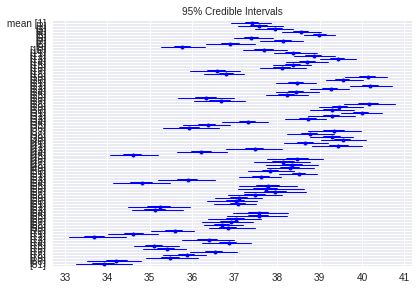

In [300]:
pymc3.forestplot(trend_gev_trace,varnames=['mean'])

# Univariate GEV DLM for synthetic data

100%|██████████| 2500/2500 [02:10<00:00, 19.01it/s]


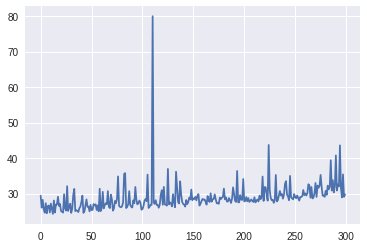

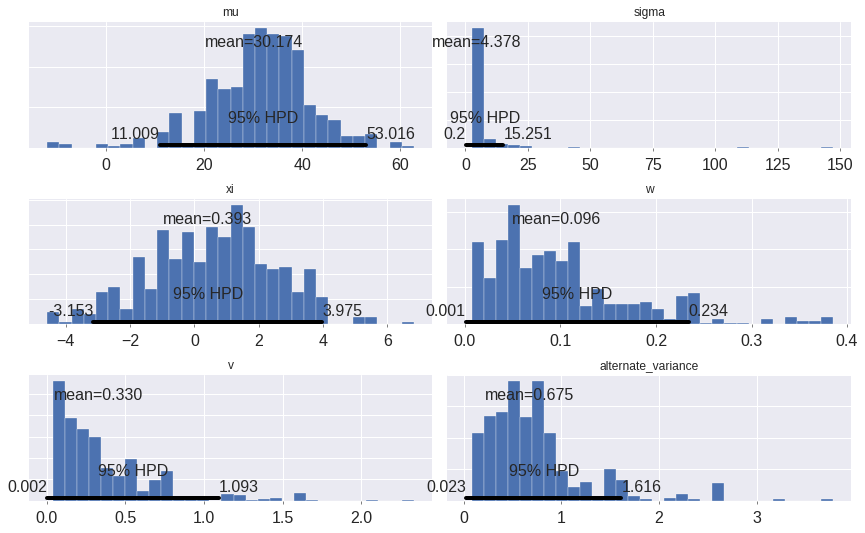

In [248]:
T = 300
true_mu    = np.linspace(25,30,T)
true_sigma = 1.0
true_xi    = 0.4
synthetic = np.zeros(T)
for i in range(T):
    synthetic[i] = genextreme.rvs(-true_xi,scale=true_sigma,loc=true_mu[i])
plt.plot(synthetic)   

r = 1
n = 1
with pymc3.Model() as synthetic_gev_model:
    # Static variables
    mu    = pymc3.Normal('mu',mu = 30.0, sd = 10.0,testval = 25.0)
    xi    = pymc3.Normal('xi',mu = 0.0, sd = 2.0,testval = 1.0)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,testval = 1.0)
   
    # DLM part
    state  = pymc3.Flat('state',shape = [T,1])
    m0     = pymc3.Normal('m0',mu = 1.0, sd = 5.0,shape = [1])
    w      = pymc3.Exponential('w',lam = 10,testval = 0.1)
    v      = pymc3.Exponential('v',lam = 3,testval = 0.1)
    alternate_variance = pymc3.InverseGamma('alternate_variance',alpha = 1.0,beta = 1.0)
   
    F      = np.asarray([[[1.0]]]).repeat(T,axis = 0)
    G      = np.asarray([[1.0]])
    
    latent = pymc3.Normal('latent',mu = state,sd = tt.sqrt(alternate_variance),shape = [T,1])
    locs   = pymc3.Deterministic('locs',latent + mu)
    
    
    step1 = pymc3.Metropolis([mu,xi,sigma,latent,m0,w,v,alternate_variance])
    step2 = FFBS_sample([mu,xi,sigma,state,m0,w,v],F,G,r,n,'latent')
    
    observations = pymc3.DensityDist('observations',gev_ll(locs,xi,sigma),
                                     observed = synthetic)
    synthetic_gev_trace = pymc3.sample(draw = 1000,step = [step1,step2],tune = 2000)
    pymc3.plot_posterior(synthetic_gev_trace,varnames=['mu','sigma','xi','w','v','alternate_variance'])

(25, 35)

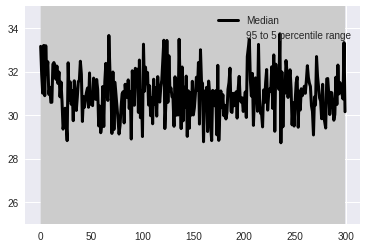

In [252]:
tsSamplesPlot(synthetic_gev_trace['locs'][:,:])
plt.ylim([25,35])

# Testing DLM without MCMC



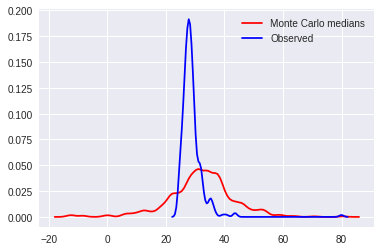

In [255]:
sample_medians = genextreme.median(-synthetic_gev_trace['xi'][:,np.newaxis].repeat(T,axis = 1),
                                        loc=np.squeeze(synthetic_gev_trace['locs'])
                                        ,scale=synthetic_gev_trace['sigma'][:,np.newaxis].repeat(T,axis = 1)).ravel()
sns.kdeplot(sample_medians,color='r',label = 'Monte Carlo medians')
sns.kdeplot(synthetic,color='b',label='Observed' )


These plots show that this setup cannot recover a basic linear trend in the location parameter.

# Modeling a single series of GEV data with random walk DLM on added latent process

In this section, we're using a random walk time series process to model deviations in the location parameter of the GEV distribution. We want the DLM state process to be relatively smooth and thus we'll set our prior on the observational variance to be relatively high compared to the evolution variance. 

100%|██████████| 5500/5500 [00:37<00:00, 146.34it/s]


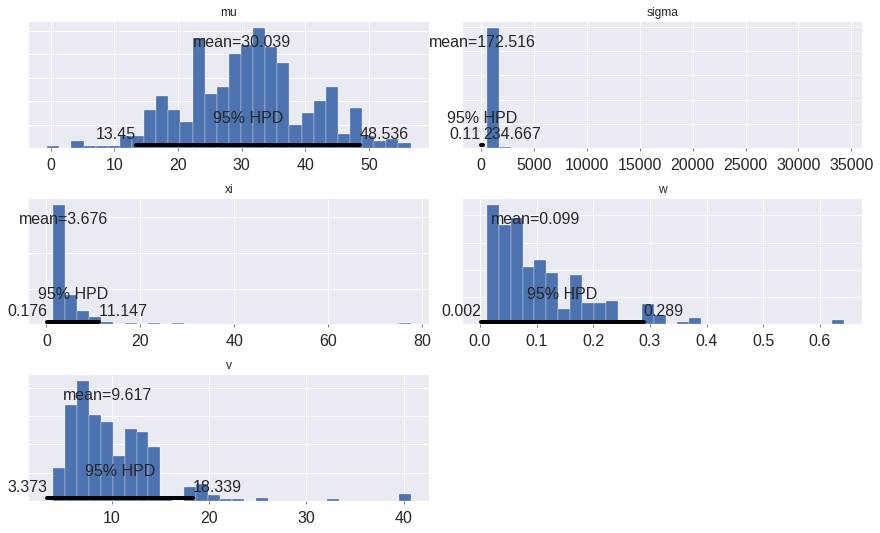

In [113]:
single_series = maxima.values[:,[0]]
T = 31
r = 1
n = 1
with pymc3.Model() as basic_gev_model:
    # Static variables
    mu    = pymc3.Normal('mu',mu = 30.0, sd = 10.0,testval = 25.0)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,testval = 1.0)
    sigma = pymc3.InverseGamma('sigma',alpha = 0.5,beta = 0.5,testval = 1.0)
   
    # DLM part
    state  = pymc3.Flat('state',shape = [31,1])
    m0     = pymc3.Normal('m0',mu = 1.0, sd = 5.0,shape = [1])
    w      = pymc3.Exponential('w',lam = 10,testval = 0.1)
    v      = pymc3.Exponential('v',lam = 3,testval = 0.1)
   
    F      = np.asarray([[[1.0]]]).repeat(T,axis = 0)
    G      = np.asarray([[1.0]])
    
    latent = pymc3.Normal('latent',mu = state,sd = tt.sqrt(v),shape = [31,1])
    locs   = pymc3.Deterministic('locs',latent + mu)
    
    
    step1 = pymc3.Metropolis([mu,xi,sigma,latent,m0,w,v])
    step2 = FFBS_sample([mu,xi,sigma,state,m0,w,v],F,G,r,n,'latent')
    
    observations = pymc3.DensityDist('observations',gev_ll(locs,xi,sigma),
                                     observed = single_series)
    basic_gev_trace = pymc3.sample(draw = 2000,step = [step1,step2],tune = 5000)
    pymc3.plot_posterior(basic_gev_trace,varnames=['mu','sigma','xi','w','v'])

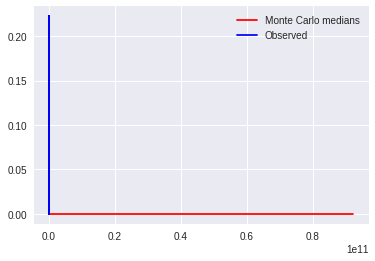

In [114]:
mc_medians = genextreme.median(-basic_gev_trace['xi'][:,np.newaxis].repeat(T,axis=1),
                loc = np.squeeze(basic_gev_trace['locs']),
                scale = basic_gev_trace['sigma'][:,np.newaxis].repeat(T,axis=1))

sns.kdeplot(mc_medians.ravel(),color='r',label = 'Monte Carlo medians')
sns.kdeplot(single_series.ravel(),color='b',label='Observed' )

# Modeling multiple series of GEV data with constant DLM on location parameters

# Modeling large numbers of GEV time series with low dimensional state vector

100%|██████████| 3500/3500 [00:59<00:00, 58.68it/s]


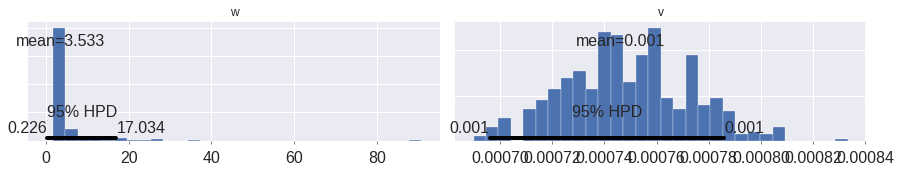

In [36]:
r = 81
T = 31
n = 3
multiple_series = maxima.values[:,0:r]
with pymc3.Model() as multiple_gev_model:
    
    # GEV variables
    mu    = pymc3.Normal('mu',mu = 30.0, sd = 15.0,shape = r)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,testval = 1.0,shape = r)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,testval = 1.0,shape = r)
   
    # DLM part
    state  = pymc3.Flat('state',shape = [31,n])
    m0     = pymc3.Normal('m0',mu = 1.0, sd = 1.0,shape = [n])
    w      = pymc3.InverseGamma('w',alpha = 1.0,beta = 1.0,testval = 0.1)
    v      = pymc3.InverseGamma('v',alpha = 0.5,beta = 0.5,testval = 0.1)
    
    # static_F has shape [n,r]
    static_F = np.identity(n).repeat(r/n,axis = 1)
    F        = static_F[np.newaxis,:,:].repeat(T,axis = 0)
    G      = np.identity(n)
    
    latent = pymc3.Normal('latent',mu = tt.dot(state,static_F),sd = tt.sqrt(v),shape = [31,r])
    locs   = pymc3.Deterministic('locs',latent + mu)
    
    
    step1 = pymc3.Metropolis([mu,xi,sigma,latent,m0,w,v])
    step2 = FFBS_sample([mu,xi,sigma,state,m0,w,v],F,G,r,n,'latent')
    
    observations = pymc3.DensityDist('observations',gev_ll(locs,xi,sigma),
                                     observed = multiple_series)
    multiple_gev_trace = pymc3.sample(step = [step1,step2],tune = 3000)
    pymc3.plot_posterior(multiple_gev_trace,varnames=['w','v'])

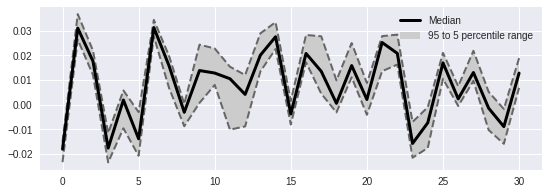

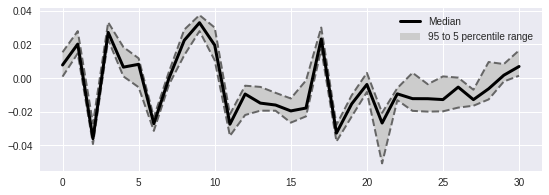

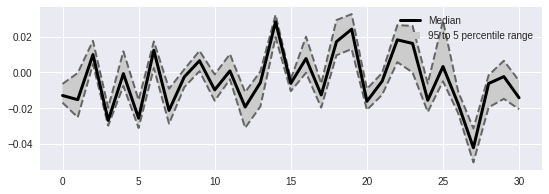

In [37]:
for i in range(n):
    plt.figure(figsize = (9,3))
    tsSamplesPlot(multiple_gev_trace['latent'][:,:,i])

# Spatialized version of GEV DLM with constant model

100%|██████████| 2500/2500 [00:45<00:00, 55.46it/s]


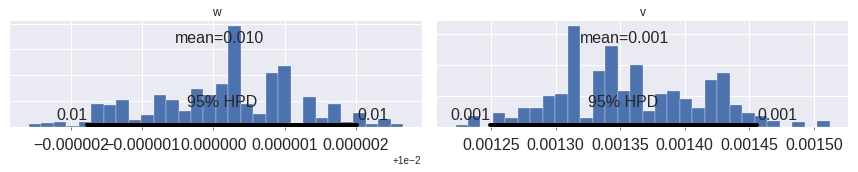

In [54]:
n_kernels = 9
kernel_sites= [(-100,40),(-96,40),(-100,36),(-96,36)]
K = createK(prods,kernel_sites)
r = 81
T = 31
n = 4
with pymc3.Model() as spatial_gev_model:
    
    # GEV variables
    mu    = pymc3.Normal('mu',mu = 30.0, sd = 15.0,shape = r)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,testval = 1.0,shape = r)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,testval = 1.0,shape = r)
   
    # DLM part
    state  = pymc3.Flat('state',shape = [31,n])
    m0     = pymc3.Normal('m0',mu = 1.0, sd = 1.0,shape = [n])
    w      = pymc3.InverseGamma('w',alpha = 1.0,beta = 1.0,testval = 0.1)
    v      = pymc3.InverseGamma('v',alpha = 1.0,beta = 1.0,testval = 0.1)
    
    # static_F has shape [n,r]
    static_F = K.T
    F        = static_F[np.newaxis,:,:].repeat(T,axis = 0)
    G      = np.identity(n)
    
    latent = pymc3.Normal('latent',mu = tt.dot(state,static_F),sd = tt.sqrt(v),shape = [31,r])
    locs   = pymc3.Deterministic('locs',latent + mu)
    
    
    step1 = pymc3.Metropolis([mu,xi,sigma,latent,m0,w,v])
    step2 = FFBS_sample([mu,xi,sigma,state,m0,w,v],F,G,r,n,'latent')
    
    observations = pymc3.DensityDist('observations',gev_ll(locs,xi,sigma),
                                     observed = multiple_series)
    spatial_gev_trace = pymc3.sample(step = [step1,step2],tune = 2000)
    pymc3.plot_posterior(spatial_gev_trace,varnames=['w','v'])

IndexError: index 4 is out of bounds for axis 2 with size 4

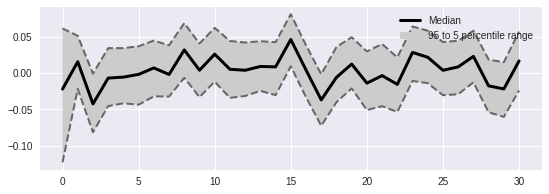

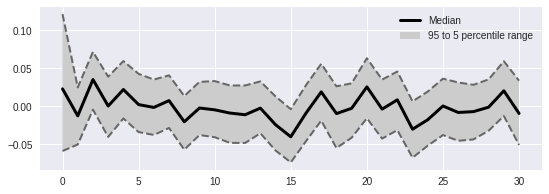

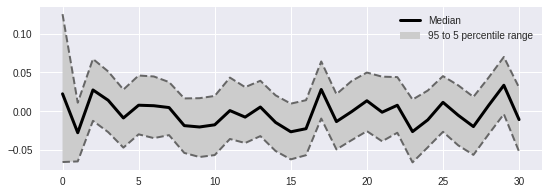

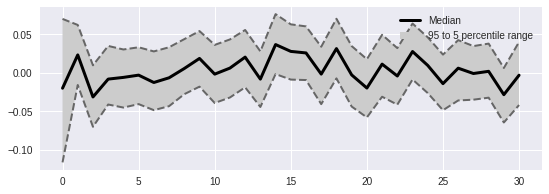

In [73]:
for i in range(n):
    plt.figure(figsize = (9,3))
    tsSamplesPlot(spatial_gev_trace['state'][:,:,i])

# Spatialized version of GEV DLM with polynomial model

100%|██████████| 2500/2500 [00:50<00:00, 49.22it/s]


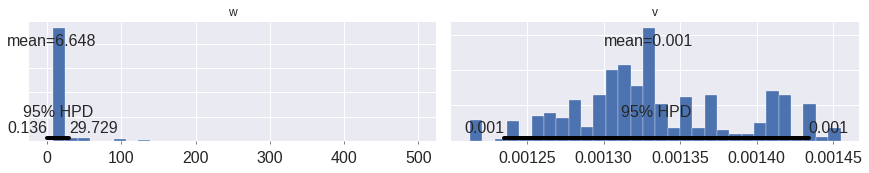

In [77]:
n_kernels        = 4
state_per_kernel = 2
n                = n_kernels * state_per_kernel
r                = 81

polynomial_evolution = np.asarray([[1,1],[0,1]])
G = np.kron(np.identity(n_kernels),polynomial_evolution)

pick_off_every_2nd = np.empty([n_kernels,n])
pick_off_every_2nd[:,::2] = np.identity(n_kernels)
pick_off_every_2nd[:,1::2] = np.zeros(n_kernels)
static_F = (K.dot(pick_off_every_2nd)).T

with pymc3.Model() as poly_gev_model:
    
    # GEV variables
    mu    = pymc3.Normal('mu',mu = 30.0, sd = 15.0,shape = r)
    xi    = pymc3.InverseGamma('xi',alpha = 1.0,beta = 1.0,testval = 1.0,shape = r)
    sigma = pymc3.InverseGamma('sigma',alpha = 1.0,beta = 1.0,testval = 1.0,shape = r)
   
    # DLM part
    state  = pymc3.Flat('state',shape = [31,n])
    m0     = pymc3.Normal('m0',mu = 1.0, sd = 1.0,shape = [n])
    w      = pymc3.InverseGamma('w',alpha = 1.0,beta = 1.0,testval = 0.1)
    v      = pymc3.InverseGamma('v',alpha = 1.0,beta = 1.0,testval = 0.1)
  
    F      = static_F[np.newaxis,:,:].repeat(T,axis = 0)
    
    latent = pymc3.Normal('latent',mu = tt.dot(state,static_F),sd = tt.sqrt(v),shape = [31,r])
    locs   = pymc3.Deterministic('locs',latent * mu)
    
    
    step1 = pymc3.Metropolis([mu,xi,sigma,latent,m0,w,v])
    step2 = FFBS_sample([mu,xi,sigma,state,m0,w,v],F,G,r,n,'latent')
    
    observations = pymc3.DensityDist('observations',gev_ll(locs,xi,sigma),
                                     observed = multiple_series)
    poly_gev_trace = pymc3.sample(step = [step1,step2],tune = 2000)
    pymc3.plot_posterior(poly_gev_trace,varnames=['w','v'])

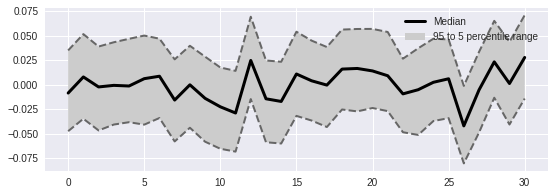

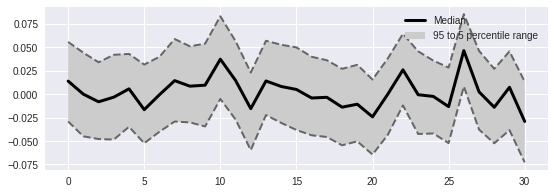

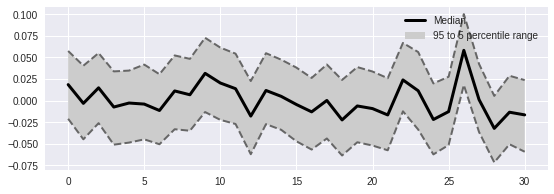

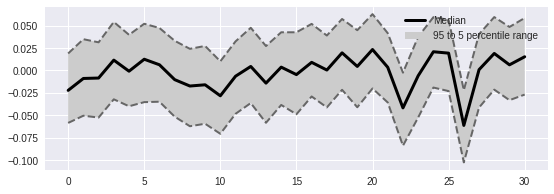

In [78]:
for i in range(n_kernels):
    plt.figure(figsize = (9,3))
    tsSamplesPlot(poly_gev_trace['state'][:,:,i*2])